In [ ]:
import sys, os, math
import numpy as np
import torch
import matplotlib.pyplot as plt

import torch.nn as nn
from torch.functional import F
import torch.distributions as dist
from torch.utils.data import DataLoader, TensorDataset, random_split

import importlib
sys.path.append('../')
from utils_modules.models import SummaryNet, Expander, Net, vector_to_Cov
from utils_modules.vicreg import vicreg_loss
import utils_modules.data as utils_data

In [ ]:
# select device; use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device: %s'%(device))

## Load data

In [ ]:
# load maps and parameters
maps      = np.load(...)[:, :, None, :, :]
dset_size = maps.shape[0] # data set size
splits    = maps.shape[1] # number of augmentations/views per parameter set

params  = np.load(...)[:, None, :]
params  = np.repeat(params, splits, axis = 1) # reshape the parameters to match the shape of the maps

# pre-process the maps data set
rescale     = True
standardize = True
verbose     = True

if rescale:
    maps = np.log(maps+1)
if standardize:
    maps_mean, maps_std = np.mean(maps, dtype=np.float64), np.std(maps, dtype=np.float64)
    maps = (maps - maps_mean)/maps_std
    
if verbose:
    print('Shape of parameters and maps:', params.shape, maps.shape)
    print('Parameter 1 range of values: [{:.3f}, {:.3f}]'.format(params[:, :, 0].min(), params[:, :, 0].max()))
    print('Parameter 2 range of values: [{:.3f}, {:.3f}]'.format(params[:, :, 1].min(), params[:, :, 1].max()))
    
    if rescale: print('Rescale: ', rescale)
    if standardize: print('Standardize: ', standardize)

maps   = torch.tensor(maps).float().to(device) 
params = torch.tensor(params).float().to(device)

In [ ]:
# divide the data into train, validation, and test sets
batch_size = 200
train_frac, valid_frac, test_frac = 0.8, 0.1, 0.1


train_dset, valid_dset, test_dset = utils_data.create_datasets(maps, params, 
                                                               train_frac, valid_frac, test_frac, 
                                                               seed = seed,
                                                               rotations=True) 


train_loader = DataLoader(train_dset, batch_size, shuffle = True)
valid_loader = DataLoader(valid_dset, batch_size, shuffle = True)
test_loader  = DataLoader(test_dset, batch_size, shuffle = False)

## Load the encoder model

In [6]:
fmodel = ...
fout   = ...

hidden     = 8
last_layer = 2*hidden

n_params   = 2
n_tril     = int(n_params * (n_params + 1) / 2)  # Number of parameters in lower triangular matrix, for symmetric matrix
n_out      = n_params + n_tril  

# load the encoder model
model = SummaryNet(hidden = hidden, last_layer = last_layer).to(device)
model.load_state_dict(torch.load(fmodel))
model.eval(); 

## Convert maps into summaries

In [7]:
x_train = []
y_train = []

x_valid = []
y_valid = []

with torch.no_grad():
    for x, y in train_loader:
        x    = x.to(device=device)
        y    = y.to(device=device)
        x_NN = model(x).to(device=device)
        
        x_train.append(x_NN)
        y_train.append(y)
        
    for x, y in valid_loader:
        x    = x.to(device=device)
        y    = y.to(device=device)
        x_NN = model(x).to(device=device)
        
        x_valid.append(x_NN)
        y_valid.append(y)

############################
x_train = torch.cat(x_train)
y_train = torch.cat(y_train)

train_dset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dset, batch_size, shuffle = True)
############################

x_valid = torch.cat(x_valid)
y_valid = torch.cat(y_valid)

valid_dset = TensorDataset(x_valid, y_valid)
valid_loader = DataLoader(valid_dset, batch_size, shuffle = True)

## Downstream task: Parameter Inference

In [8]:
# output files
fmodel_lr = ...
fout_lr   = ...

# define the network model for the downstream task
mlp_lr_units = [16*last_layer, 16*last_layer, n_out]
lr_net = Expander(mlp_lr_units, last_layer, bn = True).to(device)


In [9]:
# hyperparameters
lr         = 1e-3
epochs     = 200
lr        = 5e-4 # 1e-3

optimizer = torch.optim.AdamW(lr_net.parameters(), lr=lr, betas=(0.9, 0.999), 
                             eps=1e-8, amsgrad=False)  
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max=epochs, eta_min=lr/100, verbose=True)

        
    

In [10]:
lr_net.eval()
min_valid_loss, points = 0.0, 0
for x, y in valid_loader:
    with torch.no_grad():
        x    = x.to(device=device)
        y    = y.to(device=device)
        y_NN = lr_net(x).to(device=device) 
        
        y_pred, cov_pred = y_NN[:, :n_params], y_NN[:, n_params:]
        Cov = vector_to_Cov(cov_pred.cpu()).to(device=device)
        loss = -dist.MultivariateNormal(loc=y_pred, covariance_matrix=Cov).log_prob(y).to(device=device).mean()
        
        min_valid_loss += (loss.cpu().item())*x.shape[0]
        points += x.shape[0]
        
min_valid_loss /= points
if verbose:
    print('Initial valid loss = %.3e'%min_valid_loss)

Initial valid loss = 1.809e+00


In [11]:
# do a loop over all the epochs
for epoch in range(epochs):
    
    # training
    train_loss, num_points = 0.0, 0
    lr_net.train()
    for x,y in train_loader:
        x = x.to(device)
        y = y.to(device)
        y_NN = lr_net(x).to(device=device) 
        
        y_pred, cov_pred = y_NN[:, :n_params], y_NN[:, n_params:]
        Cov = vector_to_Cov(cov_pred.cpu()).to(device=device)
        loss = -dist.MultivariateNormal(loc=y_pred, covariance_matrix=Cov).log_prob(y).mean()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += (loss.cpu().item())*x.shape[0]
        num_points += x.shape[0]
        
    train_loss = train_loss/num_points

    # validation
    valid_loss, num_points = 0.0, 0
    lr_net.eval()
    for x,y in valid_loader:
        with torch.no_grad():
            x = x.to(device)
            y = y.to(device)            
            y_NN = lr_net(x).to(device=device) 
        
            y_pred, cov_pred = y_NN[:, :n_params], y_NN[:, n_params:]
            Cov = vector_to_Cov(cov_pred.cpu()).to(device=device)
            loss = -dist.MultivariateNormal(loc=y_pred, covariance_matrix=Cov).log_prob(y).mean()
            
            valid_loss += (loss.cpu().item())*x.shape[0]
            num_points += x.shape[0]
    valid_loss = valid_loss/num_points

    # verbose
    if valid_loss<min_valid_loss:
        min_valid_loss = valid_loss
        torch.save(lr_net.state_dict(), fmodel_lr)
        print('Epoch %d: %.3e %.3e (saving)'%(epoch, train_loss, valid_loss))
    else:
        print('Epoch %d: %.3e %.3e '%(epoch, train_loss, valid_loss))

    if epoch == 0:
        f = open(fout_lr, 'w')
    else:
        f = open(fout_lr, 'a')
    f.write('%d %.4e %.4e\n'%(epoch, train_loss, valid_loss))
    f.close()
    
    scheduler.step(valid_loss)

Epoch 0: -2.176e+00 -3.328e+00 (saving)
Epoch 1: -3.188e+00 -3.696e+00 (saving)
Epoch 2: -3.615e+00 -3.894e+00 (saving)
Epoch 3: -3.979e+00 -4.317e+00 (saving)
Epoch 4: -4.329e+00 -4.525e+00 (saving)
Epoch 5: -4.274e+00 -4.493e+00 
Epoch 6: -4.595e+00 -5.045e+00 (saving)
Epoch 7: -4.634e+00 -4.709e+00 
Epoch 8: -4.788e+00 -4.949e+00 
Epoch 9: -4.738e+00 -4.447e+00 
Epoch 10: -4.739e+00 -5.097e+00 (saving)
Epoch 11: -4.881e+00 -5.215e+00 (saving)
Epoch 12: -5.000e+00 -5.061e+00 
Epoch 13: -4.986e+00 -5.121e+00 
Epoch 14: -5.117e+00 -5.248e+00 (saving)
Epoch 15: -4.993e+00 -4.904e+00 
Epoch 16: -5.000e+00 -5.193e+00 
Epoch 17: -5.047e+00 -5.284e+00 (saving)
Epoch 18: -5.118e+00 -5.237e+00 
Epoch 19: -5.191e+00 -5.419e+00 (saving)
Epoch 20: -5.216e+00 -5.333e+00 
Epoch 21: -5.199e+00 -5.276e+00 
Epoch 22: -5.220e+00 -5.346e+00 
Epoch 23: -5.284e+00 -5.392e+00 
Epoch 24: -5.297e+00 -5.163e+00 
Epoch 25: -5.288e+00 -5.252e+00 
Epoch 26: -5.270e+00 -5.559e+00 (saving)
Epoch 27: -5.312e+00 -5

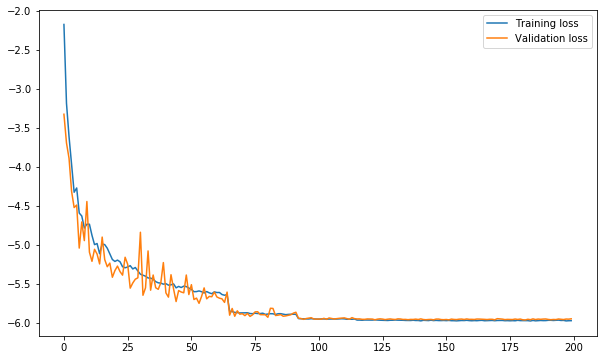

In [12]:
plt.figure(figsize = (10, 6))
losses = np.loadtxt(fout_lr)
start_epoch = 0
end_epoch = 200
plt.plot(losses[start_epoch:end_epoch, 0], losses[start_epoch:end_epoch, 1], label = 'Training loss')
plt.plot(losses[start_epoch:end_epoch, 0], losses[start_epoch:end_epoch, 2], label = 'Validation loss')
plt.legend(loc = 'best')

In [13]:
model.load_state_dict(torch.load(fmodel))
model.eval();

lr_net.load_state_dict(torch.load(fmodel_lr))
lr_net.eval(); 

test_loss, num_points = 0., 0
params_true = []
params_pred = []
errors_pred = []
with torch.no_grad(): 
    for x, y in test_loader:
        x = x.float()
        y = y.float()[:, [0, 1]]
        bs = x.shape[0]
        
        y_NN = lr_net(model(x))
        
        
        y_pred, cov_pred = y_NN[:, :n_params], y_NN[:, n_params:]
        Cov = vector_to_Cov(cov_pred.cpu()).to(device=device)
        loss = -dist.MultivariateNormal(loc=y, covariance_matrix=Cov).log_prob(y_pred).mean()
        
        test_loss += (loss.cpu().item())*x.shape[0]
        num_points += x.shape[0]
        
        params_true.append(y)
        params_pred.append(y_pred)
        errors_pred.append(Cov)
    
    test_loss = test_loss/num_points
print('Test loss: ', test_loss)

params_true = torch.cat(params_true)
params_pred = torch.cat(params_pred)  
errors_pred = torch.cat(errors_pred)
MSE_error = F.mse_loss(params_true[:, :2], params_pred[:, :2]).cpu().numpy()
print('MSE error: {:}'.format(MSE_error))

Test loss:  -5.984159717559814
MSE error: 0.00026679353322833776


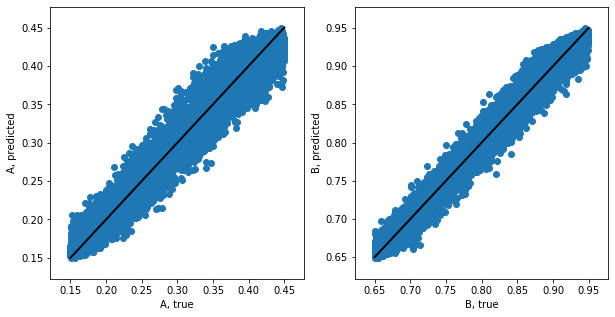

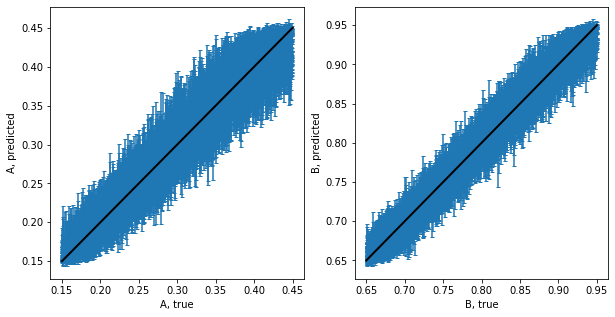

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].set_ylabel('A, predicted')
axs[0].set_xlabel('A, true')
axs[0].scatter(params_true[:, 0].cpu(), params_pred[:, 0].cpu())#, yerr=errors_pred[:, 0].cpu(), linestyle = '', capsize = 2, label = 'lr = {:.0e}'.format(lr))

axs[0].plot([0.15, 0.45], [0.15, 0.45], c = 'k', lw = 2)


axs[1].set_ylabel('B, predicted')
axs[1].set_xlabel('B, true')
axs[1].scatter(params_true[:, 1].cpu(), params_pred[:, 1].cpu()) #, yerr=errors_pred[:, 1].cpu(), linestyle = '', capsize = 2, label = 'lr = {:.0e}'.format(lr))
axs[1].plot([0.65, 0.95], [0.65, 0.95], c = 'k', lw = 2)

#################
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].set_ylabel('A, predicted')
axs[0].set_xlabel('A, true')
axs[0].errorbar(params_true[:, 0].cpu(), params_pred[:, 0].cpu(), 
               yerr=torch.sqrt(errors_pred[:, 0, 0].cpu()), linestyle = '', capsize = 2, label = 'lr = {:.0e}'.format(lr))
axs[0].plot([0.15, 0.45], [0.15, 0.45], c = 'k', lw = 2)


axs[1].set_ylabel('B, predicted')
axs[1].set_xlabel('B, true')
axs[1].errorbar(params_true[:, 1].cpu(), params_pred[:, 1].cpu(), 
               yerr=torch.sqrt(errors_pred[:, 1, 1]).cpu(), linestyle = '', capsize = 2, label = 'lr = {:.0e}'.format(lr))
axs[1].plot([0.65, 0.95], [0.65, 0.95], c = 'k', lw = 2)


In [15]:
MSE_error_scaled = F.mse_loss(params_true[:, :2], params_pred[:, :2]).cpu().numpy()
print('MSE error: {:}'.format(MSE_error_scaled))
MSE_error_scaled = F.mse_loss(params_true[:, :1], params_pred[:, :1]).cpu().numpy()
print('MSE error on OmegaM: {:}'.format(MSE_error_scaled))
MSE_error_scaled = F.mse_loss(params_true[:, 1:], params_pred[:, 1:]).cpu().numpy()
print('MSE error on sigma8: {:}'.format(MSE_error_scaled))

print('\nActual errors on A, B (relative, %)')
print((torch.abs(params_pred[:, :1] - params_true[:, :1])/params_true[:, :1]).mean()*100)
print((torch.abs(params_pred[:, 1:] - params_true[:, 1:])/params_true[:, 1:]).mean()*100)

print('\nPredicted errors on A, B (relative, %)')
print((torch.sqrt(errors_pred[:, 0, 0])/params_pred[:, :1]).mean()*100)
print((torch.sqrt(errors_pred[:, 1, 1])/params_pred[:, 1:]).mean()*100)

MSE error: 0.00026679353322833776
MSE error on OmegaM: 0.00035841023782268167
MSE error on sigma8: 0.00017517682863399386

Actual errors on A, B (relative, %)
tensor(5.1574, device='cuda:0')
tensor(1.3026, device='cuda:0')

Predicted errors on A, B (relative, %)
tensor(6.7589, device='cuda:0')
tensor(1.6474, device='cuda:0')


## Make a less crowded plot

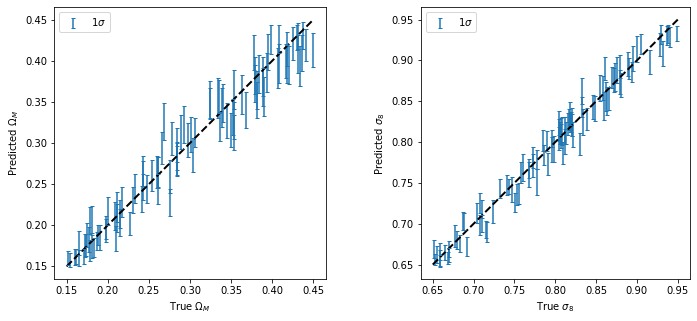

In [16]:
params_pred_plot = params_pred.cpu().numpy()
params_true_plot = params_true.cpu().numpy()
errors_pred_plot = errors_pred.cpu().numpy()

params_unique, indices_unique = np.unique(params_pred_plot[:, 0], return_index=True)
np.random.seed(seed)
np.random.shuffle(indices_unique)
indices_unique = indices_unique[:100]

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].set_ylabel('Predicted ' + r'$\Omega_M$')
axs[0].set_xlabel('True ' + r'$\Omega_M$')
axs[0].plot([0.15, 0.45], [0.15, 0.45], c = 'k', lw = 2, ls = '--')
axs[0].errorbar(params_true_plot[indices_unique, 0], params_pred_plot[indices_unique, 0], 
               yerr=np.sqrt(errors_pred_plot[indices_unique, 0, 0]), 
                linestyle = '', capsize = 2, label = r'$1\sigma$')
axs[0].set_aspect('equal')
axs[0].legend(loc = 'upper left')

axs[1].set_ylabel('Predicted ' + r'$\sigma_8$')
axs[1].set_xlabel('True ' + r'$\sigma_8$')
axs[1].plot([0.65, 0.95], [0.65, 0.95], c = 'k', lw = 2, ls = '--')
axs[1].errorbar(params_true_plot[indices_unique, 1], params_pred_plot[indices_unique, 1], 
               yerr=np.sqrt(errors_pred_plot[indices_unique, 1, 1]), 
                linestyle = '', capsize = 2, label = r'$1\sigma$')
axs[1].set_aspect('equal')
axs[1].legend(loc = 'upper left')

#plt.savefig('plots/LN_fields_VICReg_inference.jpeg')

## Test the resulting model on a particular set of parameters

In [33]:
dir_test = 'test_data/'

maps_test = np.load(dir_test+'maps_lognormal_volume_normalized_0_3_0_8.npy')[:, None, :, :]
if rescale:
    maps_test = np.log(maps_test + 1)
if standardize:
    maps_test = (maps_test - maps_mean)/maps_std
maps_test = torch.tensor(maps_test).to(device)
maps_test.shape

torch.Size([1000, 1, 100, 100])

In [34]:
model.load_state_dict(torch.load(fmodel))
model.eval();

lr_net.load_state_dict(torch.load(fmodel_lr))
lr_net.eval(); 

params_true = torch.tensor([0.3, 0.8]).unsqueeze(0).repeat(1000, 1).to(device)
with torch.no_grad(): 
    y_NN = lr_net(model(maps_test.float()))
    params_pred = y_NN[:, :n_params]
    cov_pred = y_NN[:, n_params:]
    Cov = vector_to_Cov(cov_pred.cpu()).to(device=device)
    errors_pred = Cov
    
    loss = -dist.MultivariateNormal(loc=params_true, covariance_matrix=Cov).log_prob(params_pred).mean()
    test_loss = (loss.cpu().item())*x.shape[0]
    num_points = x.shape[0]
    
params_pred = params_pred.cpu()
errors_pred = errors_pred.cpu()
params_true = params_true.cpu()

print('Loss: ', loss.cpu().numpy())
MSE_error= F.mse_loss(params_true, params_pred)
print('MSE error: {:}'.format(MSE_error))

Loss:  -5.7683277
MSE error: 0.00033922531292773783


In [35]:
print('Mean predicted error: ', torch.sqrt(errors_pred[:, 0, 0]).mean())
print('Mean predicted error (relative, %): ', (torch.sqrt(errors_pred[:, 0, 0])/params_pred[:, 0]).mean()*100)

print('\nMean predicted error: ', torch.sqrt(errors_pred[:, 1, 1]).mean())
print('Mean predicted error (relative, %): ', -(torch.sqrt(errors_pred[:, 1, 1])/params_pred[:, 1]).mean()*100)


Mean predicted error:  tensor(0.0209)
Mean predicted error (relative, %):  tensor(6.8880)

Mean predicted error:  tensor(0.0135)
Mean predicted error (relative, %):  tensor(-1.6951)


In [36]:
print('Mean predicted parameters: ', params_pred.mean(dim = 0).cpu().numpy())
print('Mean predicted covariance: ')
errors_pred.mean(dim = 0).cpu().numpy()

Mean predicted parameters:  [0.30302078 0.7990578 ]
Mean predicted covariance: 


array([[ 0.00043781, -0.00021793],
       [-0.00021793,  0.00018371]], dtype=float32)

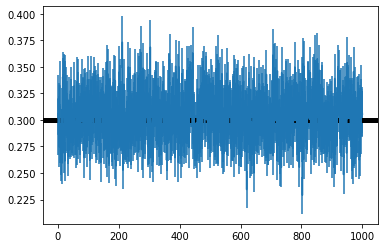

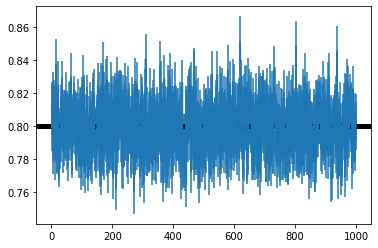

In [37]:
plt.figure(1)
plt.errorbar(np.linspace(1, maps_test.shape[0], num =maps_test.shape[0]), 
             params_pred[:, 0], yerr = torch.sqrt(errors_pred[:, 0, 0]))
plt.axhline(params_true[0, 0], lw = 5, c = 'k')

plt.figure(2)
plt.errorbar(np.linspace(1, maps_test.shape[0], num =maps_test.shape[0]), 
             params_pred[:, 1], yerr = torch.sqrt(errors_pred[:, 1, 1]))
plt.axhline(params_true[0, 1], lw = 5, c = 'k')
